## introduction
### problem statement
Every day always more people experience the opportunity of training overywhere: outdoor on a park, in a garage, in our bedroom etc. Anyway this possibility of freedom led to a great issue commont to every uncommon athlets: the lack of feedbacks.
infact, while in a gym is easy receive a examination on own exercise esecution, by a trainer or by another athlet, on own bedroom we don't have this possibility. lack of feedback on exercise esecution led to learn improper esecutin, bring to weak performances, injuries etc

### state of art 
to evaluete own proper execution, athlets sometimes use to record their performarce in order to self esaminate them and find what is wrong. Anyway this process is tedios becouse it involve the need to find a good place to put the smartphone,record the clip, skip all the preparation of exercise, find the most significative point on the esecution, examinate them and finaly understaining whats wrong for correcting mistakes on the next repetition.
Do this proces for every rep, for every exercise, in time with rest time (usualy in the order of 1 minute), can be annoing and most athlets preferes to not be distracted and keep attention on their work out.

### proposed solution 
my idea is to make all this process agile for the atlets, developing a computer vision pipeline that is able  to take the recordered clip, extrapolate the most important keyframe for the athlets, discard all the unnecessary moment to be keep user attention on the most important moment and give to final user a edited clipp to fast evaluate own performances


# Step O colab initialization

In [1]:
!git clone https://github.com/AlfaranoAndrea/workuout_keyframe.git

%cd workuout_keyframe 

!mkdir -p ./dataset/
!mkdir -p ./models/checkpoint/

!wget "drive.google.com/u/3/uc?id=16QAVQheoSCk_tWaZbBLojtJfG1mVsLzp&export=download&confirm=yes" -O ./dataset/Sintel.zip
!wget "drive.google.com/u/3/uc?id=1iAKv2S1OE3YpwgwX43bKZHxBAlluL9Y9&export=download&confirm=yes" -O ./models/checkpoint/flownets.pth.tar.pth
!unzip ./dataset/Sintel.zip -d ./dataset 

!gdown https://drive.google.com/drive/folders/148Mhwpt9E89_gLMAJC4S45DiVv83Xz54?usp=share_link --folder -O input_video

!pip install pytorch_lightning -qq
!pip install flowiz -qq

Cloning into 'workuout_keyframe'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 174 (delta 76), reused 98 (delta 38), pack-reused 4
Receiving objects: 100% (174/174), 6.03 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/workuout_keyframe
--2023-02-17 11:33:45--  http://drive.google.com/u/3/uc?id=16QAVQheoSCk_tWaZbBLojtJfG1mVsLzp&export=download&confirm=yes
Resolving drive.google.com (drive.google.com)... 142.250.153.102, 142.250.153.138, 142.250.153.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.153.102|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/u/3/uc?id=16QAVQheoSCk_tWaZbBLojtJfG1mVsLzp&export=download&confirm=yes [following]
--2023-02-17 11:33:45--  https://drive.google.com/u/3/uc?id=16QAVQheoSCk_tWaZbBLojtJfG1mVsLzp&export=download&confirm=yes
Connecting to dri

# First part: Deep Learning

In [2]:
import numpy as np
import torch
import pytorch_lightning as pl

from torchvision import datasets
import matplotlib.pyplot as plt
import flowiz as fz

from dataset import  FlowDataModule
from models.flowNetS import FlowNetS
from models.raft import RAFT

from utilities.videoUtilities import extract_frames, saveVideo
from utilities.flowUtilities import computeFlow, flowVideo
from utilities.keyFramesUtilities import find_center_of_gravity, save_key_frames
from utilities.signalUtilities import  movingAverage, findKeyPoints, normalizeZeroMean

# datasets

let's visualize how torch vison dataset FlyingChairs works

In [3]:
loadedDataset= datasets.Sintel(
    root='./dataset',
    split = "train", 
    pass_name = "final"
    )

image1 in dataset has shape: (436, 1024, 3)
image2 in dataset has shape: (436, 1024, 3)
flow image in dataset has shape: (2, 436, 1024)
flow image in dataset has this new shape: (436, 1024, 2)


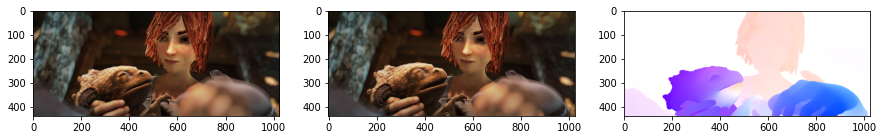

In [4]:
"""
dataset gives back triplets [image1,image2, targetFlow]
"""

triplet=loadedDataset[10]
img1,img2,flow= triplet

img1=np.asarray(img1)
img2=np.asarray(img2)

print (f"image1 in dataset has shape: {img1.shape}")
print (f"image2 in dataset has shape: {img2.shape}")

print (f"flow image in dataset has shape: {flow.shape}")
flow=np.transpose (flow,(1,2,0))
print (f"flow image in dataset has this new shape: {flow.shape}")

flow=fz.convert_from_flow(flow) 

plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(flow)



## model training

In [5]:
save = torch.load("./models/checkpoint/flownets.pth.tar.pth")
model  = FlowNetS(save, lr=1e-5)
data=FlowDataModule(batch_size =1, workers=32,selected_dataset ="Sintel")

In [6]:
trainer = pl.Trainer(accelerator= "gpu" if torch.cuda.is_available() else "cpu", 
                     max_epochs=100,             
                     auto_lr_find=False, 
                     auto_scale_batch_size=False)

trainer.fit(model,data)
model.save(path="./models/checkpoint/fineTuned.pth")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Second part: Computing Pipeline

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save = torch.load("./models/checkpoint/fineTuned.pth")
model  = FlowNetS(save)
model.to(device)
video_path= "./input_video/pullup.mp4"
temp_extracted_frames="./temp/Frames/"
temp_processed_flow_frames="./temp/processedFloFrames/"

In [9]:
fps=30
step=6
fps=int(extract_frames(video_path))
flowVideo(
    path=temp_extracted_frames,
    model=model,
    device=device,
    step=step)
saveVideo(temp_processed_flow_frames,"pippo", fps=fps)

60.097505730497886
Readed 1033  frames 


100%|██████████| 172/172 [00:00<00:00, 1262.85it/s]


In [10]:
# 3B- Find miving cordinates of center of gravity of our athlet
x,y=find_center_of_gravity(temp_processed_flow_frames)  
#saveVideo(comp,"PullUp_mass",bw=True)

100%|██████████| 172/172 [00:00<00:00, 1182.68it/s]


## SIGNAL ANALISYS

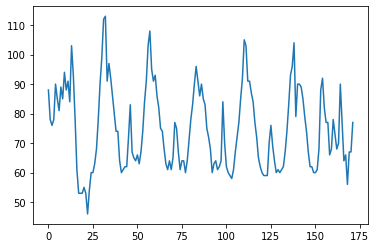

In [11]:
fig, ax = plt.subplots()
ax.plot(y)
plt.show()

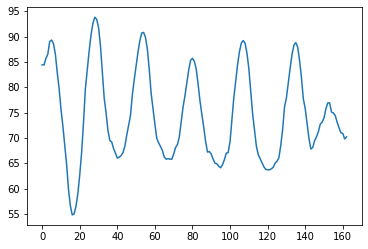

In [12]:
# 2- mobile average
#K=[0.25,0.25,0.25,0.25]


#avg=np.convolve(K,y)
avg= movingAverage(y,k=int(fps/step))
normalized= normalizeZeroMean(avg)
fig, ax = plt.subplots()
ax.plot(avg)
plt.show()

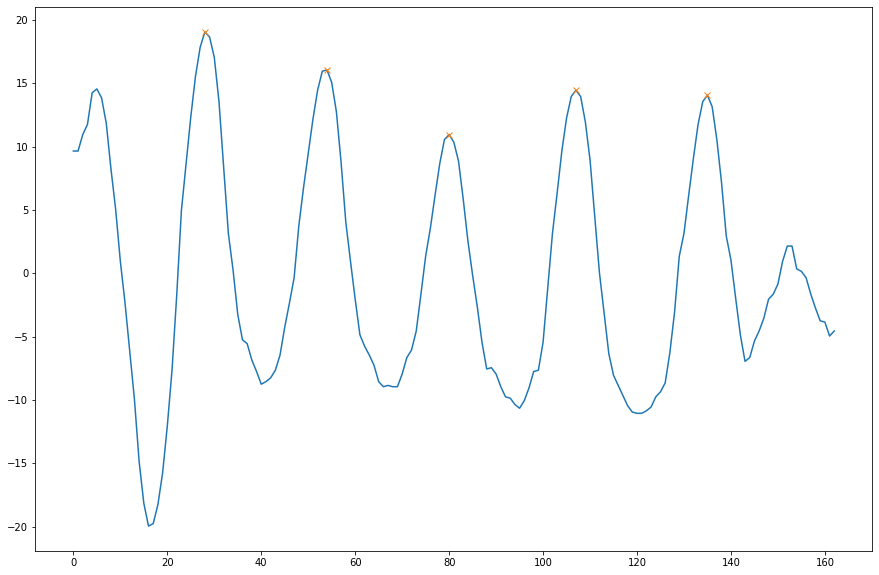

In [13]:
# 3- find peacks positive
peaks= findKeyPoints(normalized, distance=int(fps/step))


np.diff(peaks)
plt.figure(figsize=(15,10))
plt.plot(normalized)
plt.plot(peaks, normalized[peaks], "x")
plt.show()



In [14]:
save_key_frames(
    keyFramesList=peaks, 
    frames_path=temp_extracted_frames,
    threshold=12, 
    near=5, 
    slowmotion=2, 
    speedUp=4, 
    title="final.avi")

[112, 216, 320, 428, 540]


100%|██████████| 1033/1033 [00:47<00:00, 21.74it/s]
